Exploring the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import sys
import importlib
import functions.functions as aux_fun
importlib.reload(aux_fun)
from datetime import datetime as dti

from sklearn.linear_model import LinearRegression

pd.options.mode.chained_assignment = None 

#### Reading data

In [3]:
# Read data

# Portifolio and profile datasets
portfolio = pd.read_csv('portfolio.csv')
profile = pd.read_csv('profile_clustered.csv')

# User and offer data, already treated in Data Preparation 
user_offer_df = pd.read_csv('user_offer.csv').astype({'offer_id_rec':np.int8})

# User transactions
user_tra_df = pd.read_csv('user_transactions.csv')


Quick look at the data

#### Data Preparation to Analysis

Merging datasets

Merging the user offer dataset with profile and portifolio dataset  

The extra information will be used to exploring the data.

In [4]:
# Just interesting columns from profile and portifolio
# Profile
profile2 = profile[['user_id', 'gender', 'age', 'income', 'rela_member_years', 'user_cluster']]

# Portifolio
portfolio2 = portfolio[['offer_id', 'reward', 'difficulty', 'offer_type']]
portfolio2.columns = ['offer_id', 'offer_reward', 'offer_difficulty', 'offer_type']

# Merging with user_offer_id

user_offer_df2 = user_offer_df.merge(portfolio2, left_on='offer_id_rec', right_on='offer_id')
user_offer_df2 = user_offer_df2.merge(profile2, on='user_id')

user_offer_df2.head() 

,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id,offer_id,offer_reward,offer_difficulty,offer_type,gender,age,income,rela_member_years,user_cluster
0,7,1.0,0.0,49.39,1.0,NaN,0.0,3,7,0,0,informational,F,75.0,100000.0,1.21,2
1,3,1.0,1.0,19.89,1.0,1.0,5.0,3,3,5,5,bogo,F,75.0,100000.0,1.21,2
2,0,1.0,1.0,21.72,1.0,1.0,10.0,3,0,10,10,bogo,F,75.0,100000.0,1.21,2
3,8,1.0,1.0,0.00,1.0,0.0,5.0,3,8,5,5,bogo,F,75.0,100000.0,1.21,2
4,7,0.0,0.0,0.00,NaN,NaN,0.0,4,7,0,0,informational,NI,55.0,64000.0,0.98,0


Informações contínuas, como renda e idade podem ser melhor analisadas a partir da sua divisão em partes.  
O melhor agrupamento para uma única variável é nos quartis, separando os dados em 4 partes iguais. Outro agrupamento que permite obersar mais abertamente os valores é a divisão por decils

In [5]:

# Quartis da idade
user_offer_df2['age_quartile'] = pd.qcut(user_offer_df2['age'], q=4)
# user_offer_df2['age_decile'] = pd.qcut(user_offer_df2['age'], q=10)

# Quartis de renda
user_offer_df2['income_quartile'] = pd.qcut(user_offer_df2['income'], q=4)
# user_offer_df2['income_decile'] = pd.qcut(user_offer_df2['income'], q=10)

# Quartis de tempo
user_offer_df2['member_years_quartile'] = pd.qcut(user_offer_df2['rela_member_years'], q=4)

user_offer_df2.head()

,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id,offer_id,offer_reward,offer_difficulty,offer_type,gender,age,income,rela_member_years,user_cluster,age_quartile,income_quartile,member_years_quartile
0,7,1.0,0.0,49.39,1.0,NaN,0.0,3,7,0,0,informational,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
1,3,1.0,1.0,19.89,1.0,1.0,5.0,3,3,5,5,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
2,0,1.0,1.0,21.72,1.0,1.0,10.0,3,0,10,10,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
3,8,1.0,1.0,0.00,1.0,0.0,5.0,3,8,5,5,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
4,7,0.0,0.0,0.00,NaN,NaN,0.0,4,7,0,0,informational,NI,55.0,64000.0,0.98,0,"(45.0, 55.0]","(51000.0, 64000.0]","(0.57, 0.98]"


Selecionando clunas chaves para análise

Situação:  

Quando uma oferta é recebida, ela é vista ou não | **viewed_rate**  
Ela pode ser completada sem mesmo ser vista | **completed_after_view_rate**

A transação influenciada por ela depende de:  
1. A transação ser realizada depois da oferta **ser visualizada**
2. A transação ser realizada antes de **ser completada** 
3. A transação ser realizada antes da **visualização da próxima oferta**  

In [6]:
# Treating the valid viewed rate 

# A oferta pode ter sido vista, porém não foi vista em tempo de validade da oferta
# A coluna de vizualições válidas entrega esse valor
# Basta substituir os NaN por 0, já que não foi visualizada
user_offer_df2['valid_view_rate'] = user_offer_df2['valid_view_rate'].fillna(0)
user_offer_df2.valid_view_rate.isna().sum()

0

In [7]:
# A taxa de completação tem duas. Pode ser após a oferta ter sido vista, o que 
# pode-se implicar que a oferta influenciou a completação ou ter sido completada
# sem ter sido vista, o que não pode ser considerada influenciadora no usuário

user_offer_df2['completed_after_view_rate'] = user_offer_df2['completed_after_view_rate'].fillna(0)
user_offer_df2.completed_after_view_rate.isna().sum()
# user_offer_df2.loc[user_offer_df2.completed_after_view_rate==0]

0

As duas colunas principais para análise de visualização e completação vai ser as colunas **valid_view_rate** e **completed_after_view_rate**

Quando a oferta é completa, necessáriamente ela precisa ser visualizada.  
Se o objetivo for aumentar o nível de visualização, a variável de visualização deve ser avaliada.   
Caso a mira seja aumenta a completação das ofertas, então a taxa de completação deve ser avaliada.  

A melhor métrica, afinal, é o total de transações feitos por usuários a partir da oferta.  
Se a oferta for feita de forma correta para cada grupo, então o total de trasações irá aumentar.  

Como analisar os melhores grupos para enviar as ofertas.  

Como prever o total de transação feito para cada 

Limpando a base e melhorando os nomes

In [8]:
user_offer_df3 = user_offer_df2[['offer_id_rec', 'user_id',
    'valid_view_rate', 'completed_after_view_rate','tra_offer_infl', 'offer_type', 
    'gender', 'age', 'income', 'rela_member_years', 'user_cluster', 'age_quartile',
    'income_quartile', 'member_years_quartile']]

user_offer_df3.head()

,offer_id_rec,user_id,valid_view_rate,completed_after_view_rate,tra_offer_infl,offer_type,gender,age,income,rela_member_years,user_cluster,age_quartile,income_quartile,member_years_quartile
0,7,3,1.0,0.0,49.39,informational,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
1,3,3,1.0,1.0,19.89,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
2,0,3,1.0,1.0,21.72,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
3,8,3,1.0,0.0,0.00,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
4,7,4,0.0,0.0,0.00,informational,NI,55.0,64000.0,0.98,0,"(45.0, 55.0]","(51000.0, 64000.0]","(0.57, 0.98]"


In [161]:
user_offer_df3.to_csv('user_offer2.csv', index=False)

In [162]:
user_offer_df2

,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id,offer_id,offer_reward,offer_difficulty,offer_type,gender,age,income,rela_member_years,user_cluster,age_quartile,income_quartile,member_years_quartile
0,7,1.0,0.0,49.39,1.0,0.000000,0.0,3,7,0,0,informational,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
1,3,1.0,1.0,19.89,1.0,1.000000,5.0,3,3,5,5,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
2,0,1.0,1.0,21.72,1.0,1.000000,10.0,3,0,10,10,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
3,8,1.0,1.0,0.00,1.0,0.000000,5.0,3,8,5,5,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
4,7,0.0,0.0,0.00,0.0,0.000000,0.0,4,7,0,0,informational,NI,55.0,64000.0,0.98,0,"(45.0, 55.0]","(51000.0, 64000.0]","(0.57, 0.98]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,5,1.0,1.0,14.83,1.0,1.000000,6.0,9950,5,3,7,discount,M,21.0,45000.0,0.44,3,"(17.999, 45.0]","(29999.999, 51000.0]","(-0.001, 0.57]"
63284,5,1.0,1.0,14.95,1.0,1.000000,3.0,3615,5,3,7,discount,F,63.0,68000.0,0.96,0,"(55.0, 64.0]","(64000.0, 76000.0]","(0.57, 0.98]"
63285,5,1.0,1.0,30.41,1.0,1.000000,12.0,6691,5,3,7,discount,F,68.0,51000.0,1.15,0,"(64.0, 101.0]","(29999.999, 51000.0]","(0.98, 2.17]"
63286,5,1.0,1.0,14.25,1.0,1.000000,3.0,15432,5,3,7,discount,M,20.0,70000.0,1.77,3,"(17.999, 45.0]","(64000.0, 76000.0]","(0.98, 2.17]"


#### Exploring the data

Quantidade de ofertas enviadas de cada tipo

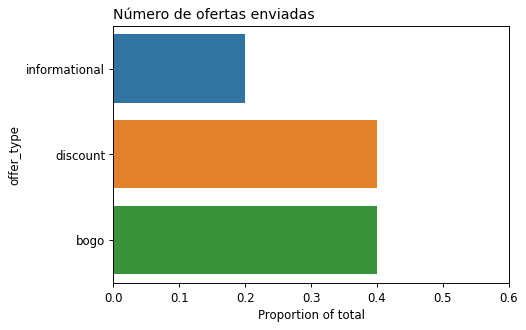

In [9]:
aux_fun.plot_by_category_metric(df=user_offer_df3, 
        col_category='offer_type',
        metric='user_id',
        title='Número de ofertas enviadas',
        x_label='Proportion of total',
        y_label='offer_type',
        xlims=[0,0.6],
        agg='proportion'
        )

In [10]:
# A quantidade de ofertas distribuídas se equivale a quantida de ofertas
# no dataset de portifolio
portfolio.groupby('offer_type').agg({'offer_type':'count'}) / portfolio2.shape[0]

,offer_type
offer_type,
bogo,0.4
discount,0.4
informational,0.2


Se distribui como na quantidade total.  
Assim como no profile.

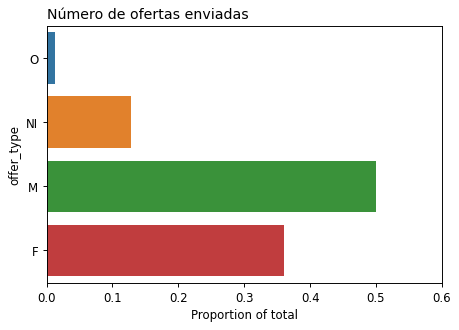

In [11]:
aux_fun.plot_by_category_metric(df=user_offer_df3, 
        col_category='gender',
        metric='user_id',
        title='Número de ofertas enviadas',
        x_label='Proportion of total',
        y_label='offer_type',
        xlims=[0,0.6],
        agg='proportion'
        )

In [12]:
(profile2.groupby('gender').agg({'gender':'count'}) / profile2.shape[0]).round(2)

,gender
gender,
F,0.36
M,0.50
NI,0.13
O,0.01


By Offer Type

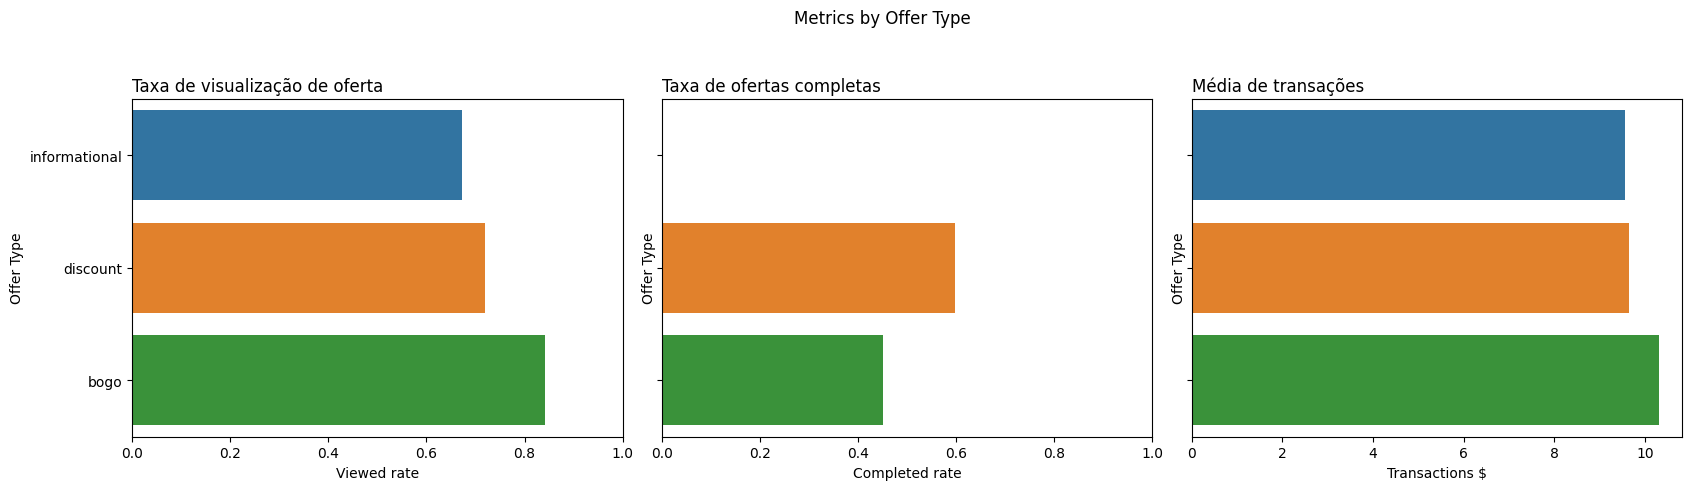

In [13]:
importlib.reload(aux_fun)
aux_fun.plot_grid_metrics(user_offer_df3, 'offer_type')

COMENTAR AQUI

By Offer ID and Offer Type

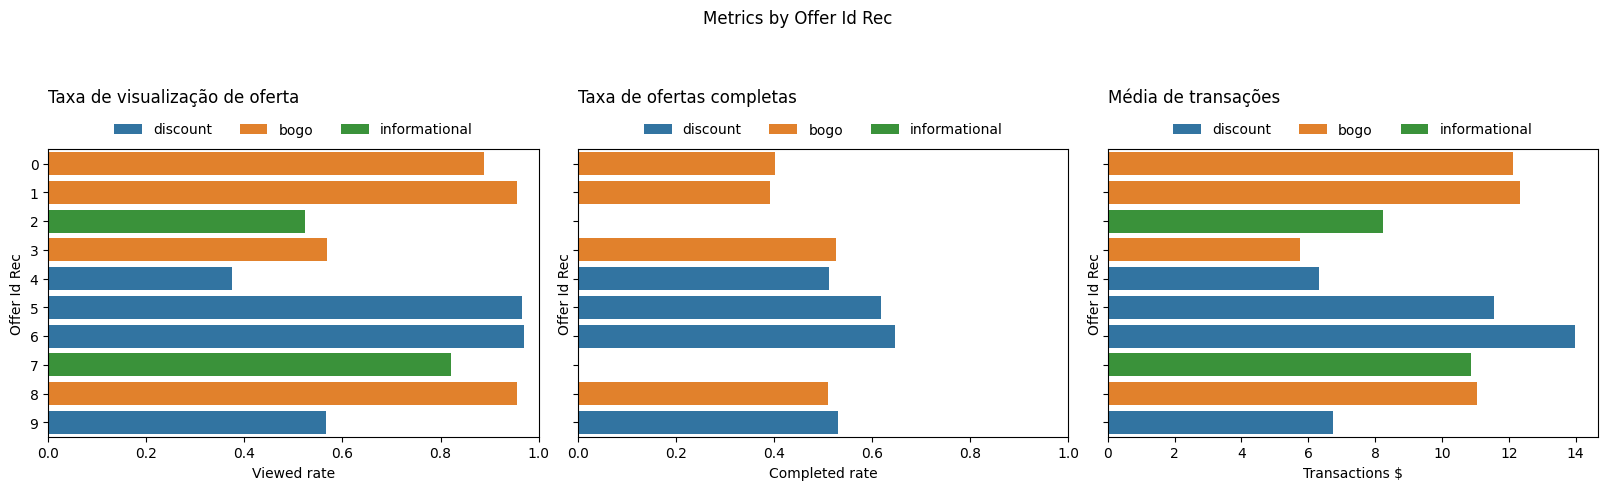

In [14]:
importlib.reload(aux_fun)

aux_fun.plot_grid_metrics(user_offer_df2, ['offer_id_rec', 'offer_type'])

By Gender

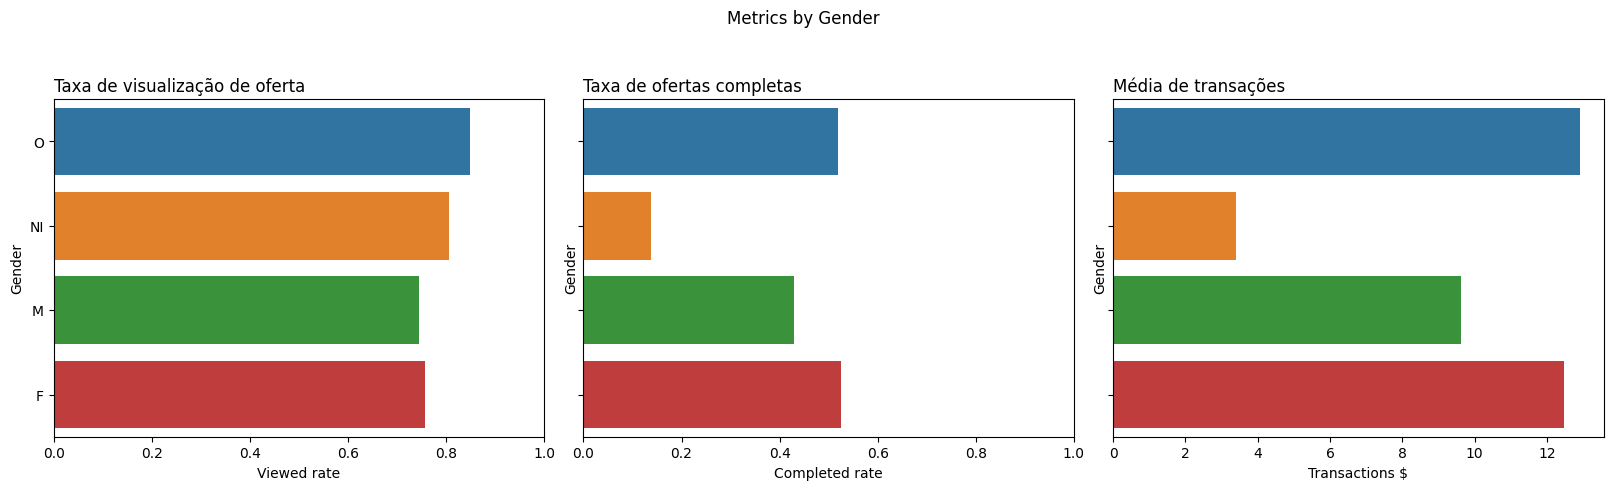

In [15]:
importlib.reload(aux_fun)

aux_fun.plot_grid_metrics(user_offer_df3, 'gender')

Maiores para outros pq a quantidade de pessoas é menor.   

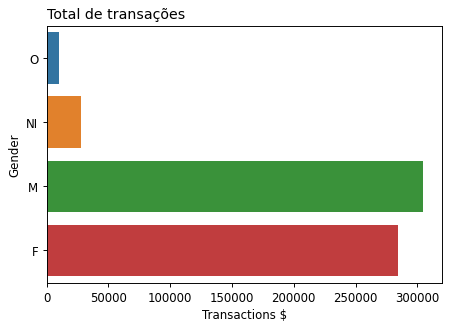

In [16]:
# Ploting total of transactions
aux_fun.plot_by_category_metric(df=user_offer_df3, 
        col_category='gender',
        metric='tra_offer_infl',
        title='Total de transações',
        x_label='Transactions $',
        y_label='Gender',
        agg='sum'
        )

In [17]:
user_offer_df3.groupby('gender')['tra_offer_infl'].sum() / user_offer_df3['tra_offer_infl'].sum()

gender
F     0.453893
M     0.486428
NI    0.043804
O     0.015874
Name: tra_offer_infl, dtype: float64

By Gender and Offer Type

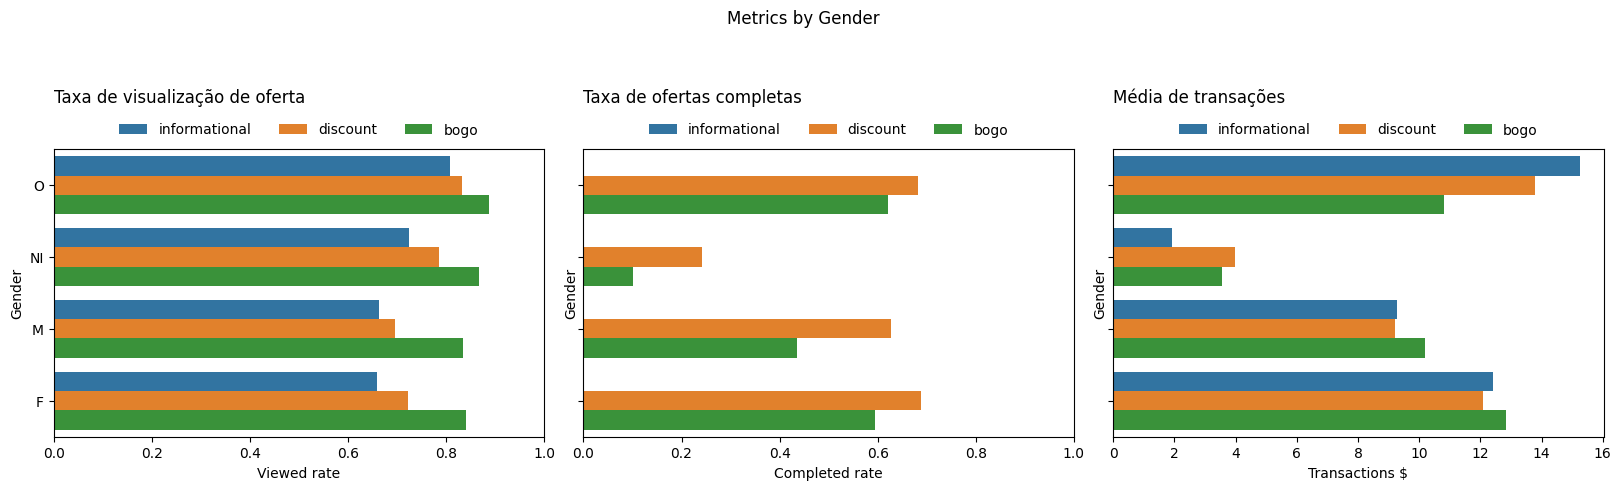

In [18]:
importlib.reload(aux_fun)

aux_fun.plot_grid_metrics(user_offer_df3, ['gender', 'offer_type'], dodge=True)

By Age

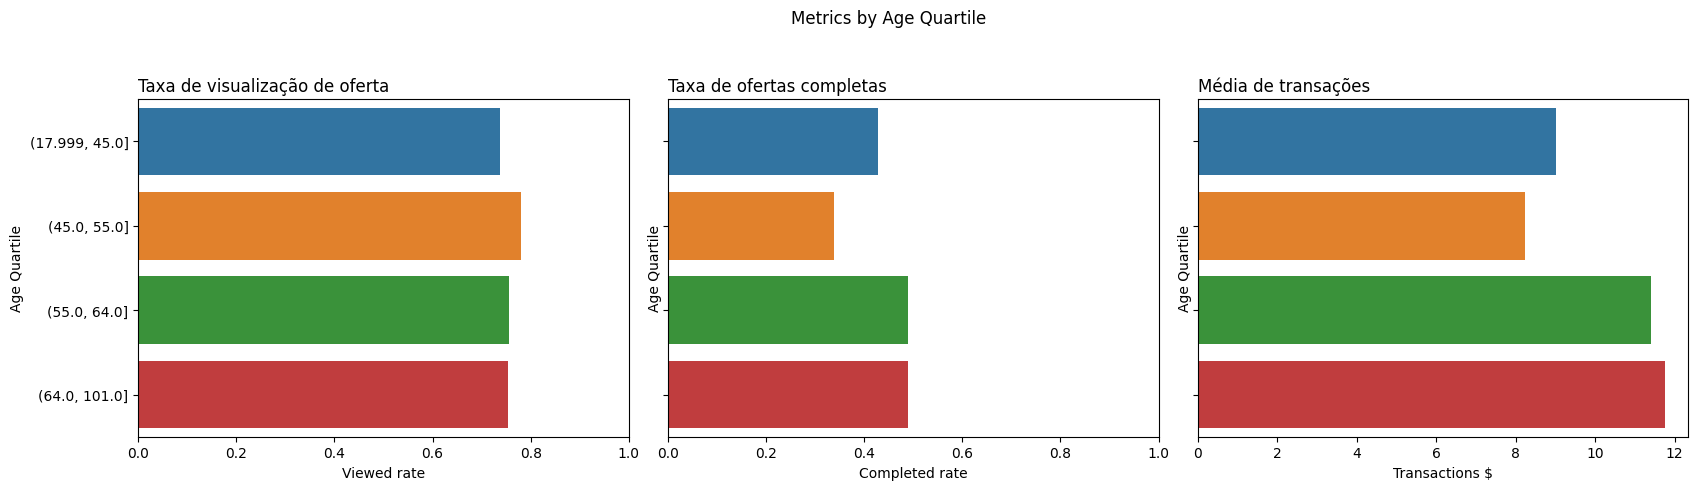

In [19]:
importlib.reload(aux_fun)

aux_fun.plot_grid_metrics(user_offer_df3, 'age_quartile')

Transações por idade

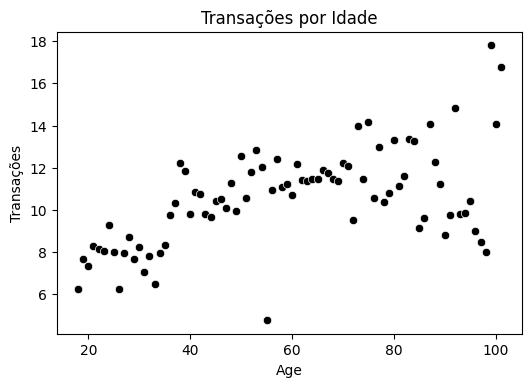

In [20]:
# Plotando transações por idade, variável contínua
plt.figure(dpi=100)

plot_df = user_offer_df3.groupby('age', as_index=False)['tra_offer_infl'].mean()
sns.scatterplot(data=plot_df, x='age', y='tra_offer_infl', color='black')
plt.title('Transações por Idade')
plt.xlabel('Age')
plt.ylabel('Transações')
plt.show()

By Age and Offer Type

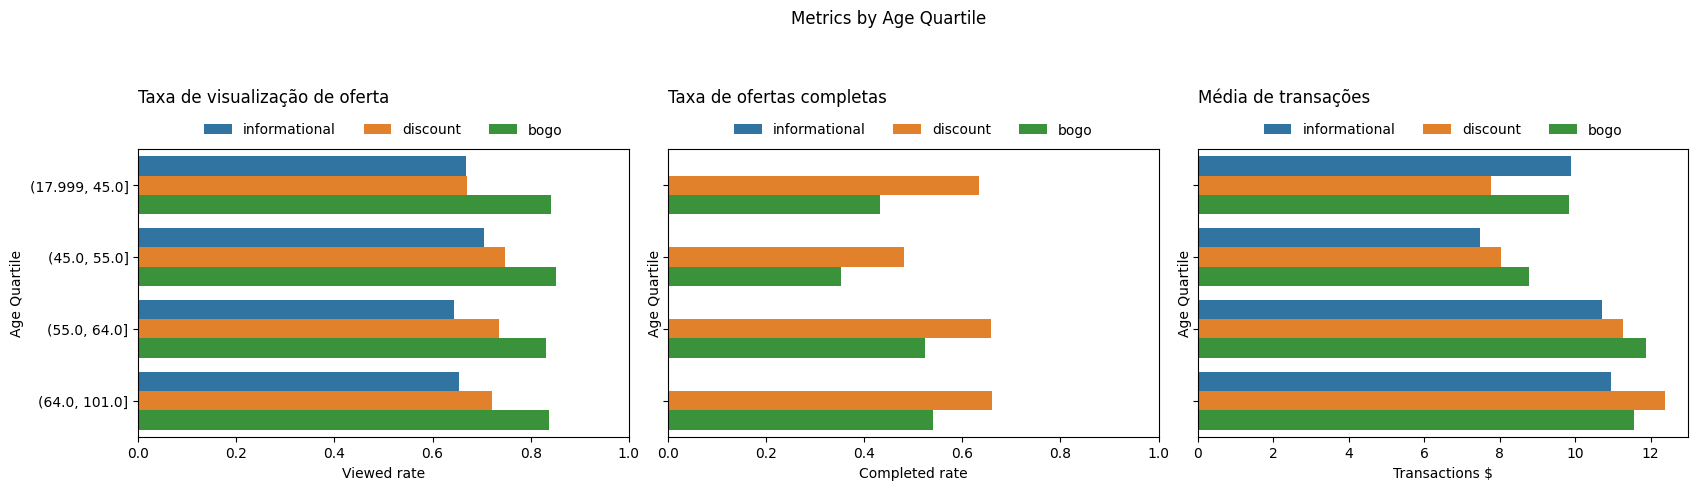

In [21]:

aux_fun.plot_grid_metrics(user_offer_df3, ['age_quartile','offer_type'], dodge=True)

<Figure size 1512x288 with 0 Axes>

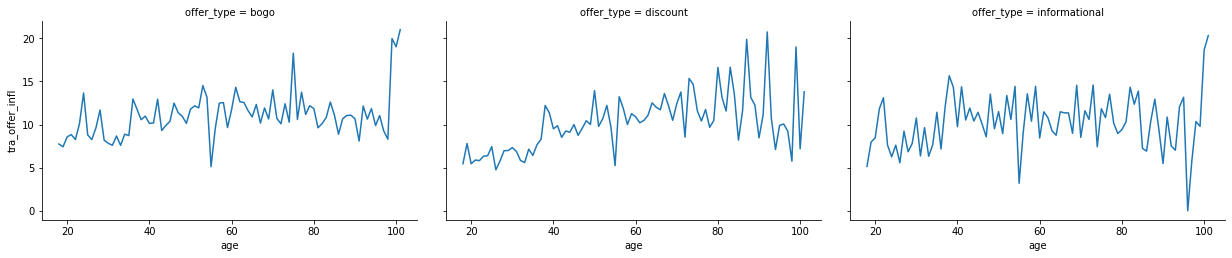

In [22]:
plt.figure(figsize=(21,4))

plot_df = user_offer_df3.groupby(['age','offer_type'], as_index=False)['tra_offer_infl'].mean()
g = sns.FacetGrid(data=plot_df, col='offer_type', sharey=True)
g.map_dataframe(sns.lineplot, x='age', y='tra_offer_infl')
plt.gcf().set_size_inches(18,4)
# plt.title('Transações por Idade')
# plt.xlabel('Age')
# plt.ylabel('Transações')
# plt.show()

By Member Since

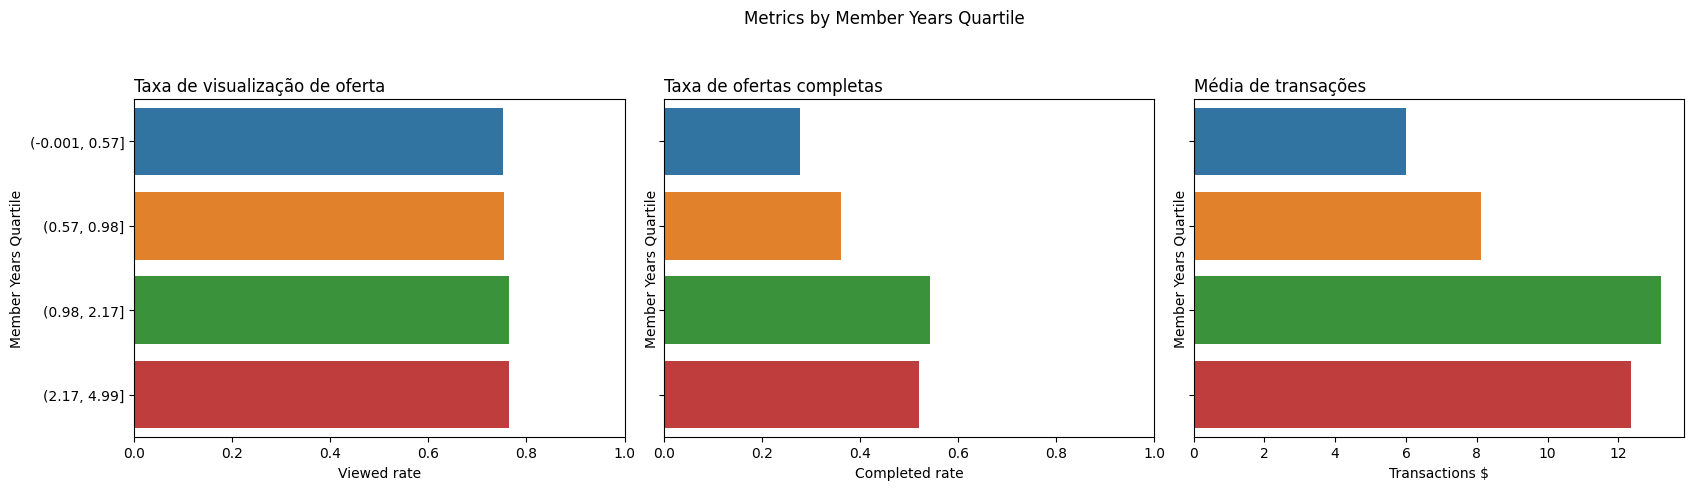

In [23]:
aux_fun.plot_grid_metrics(user_offer_df3, 'member_years_quartile', dodge=True)

By Member Since and Offer_Type

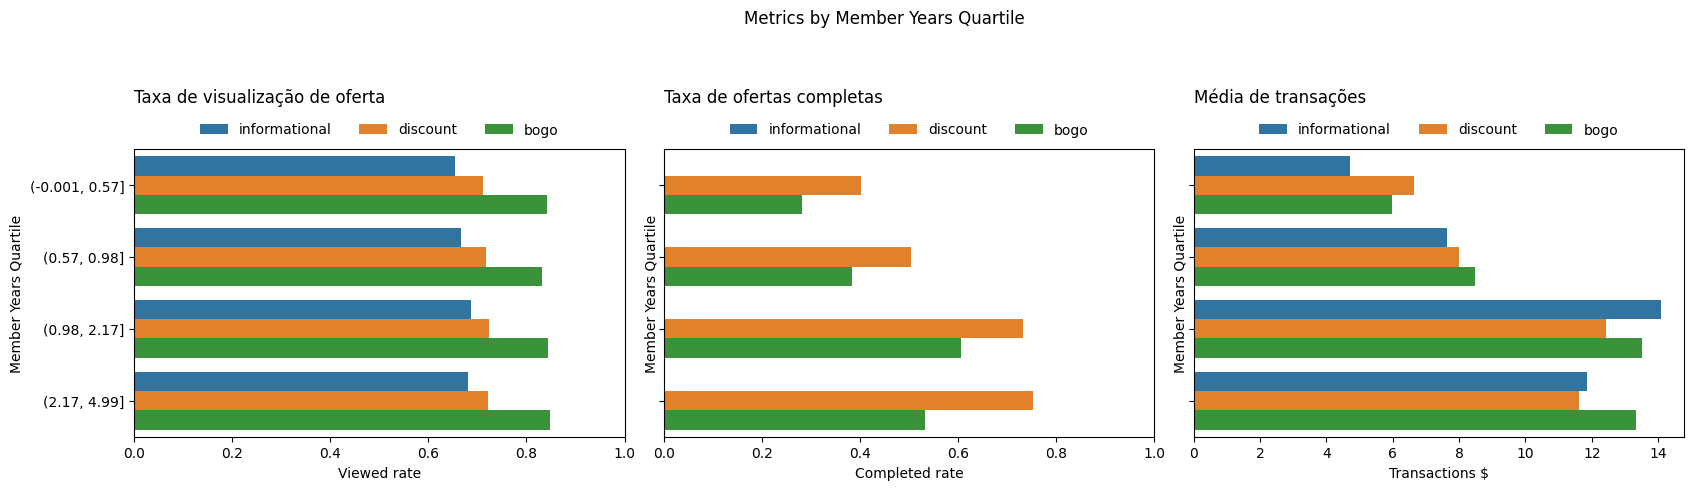

In [24]:
aux_fun.plot_grid_metrics(user_offer_df3, ['member_years_quartile', 'offer_type'], dodge=True)

By Income

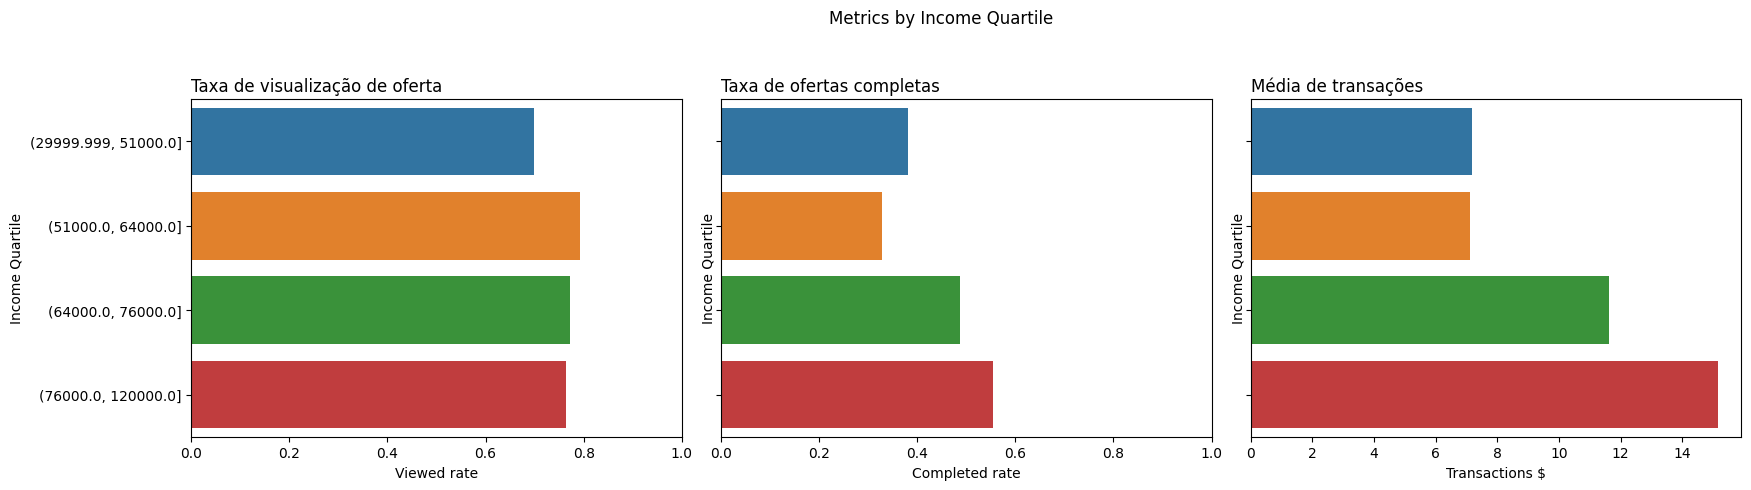

In [25]:
aux_fun.plot_grid_metrics(user_offer_df3, 'income_quartile', dodge=True)

By Income and Offer Proprieties

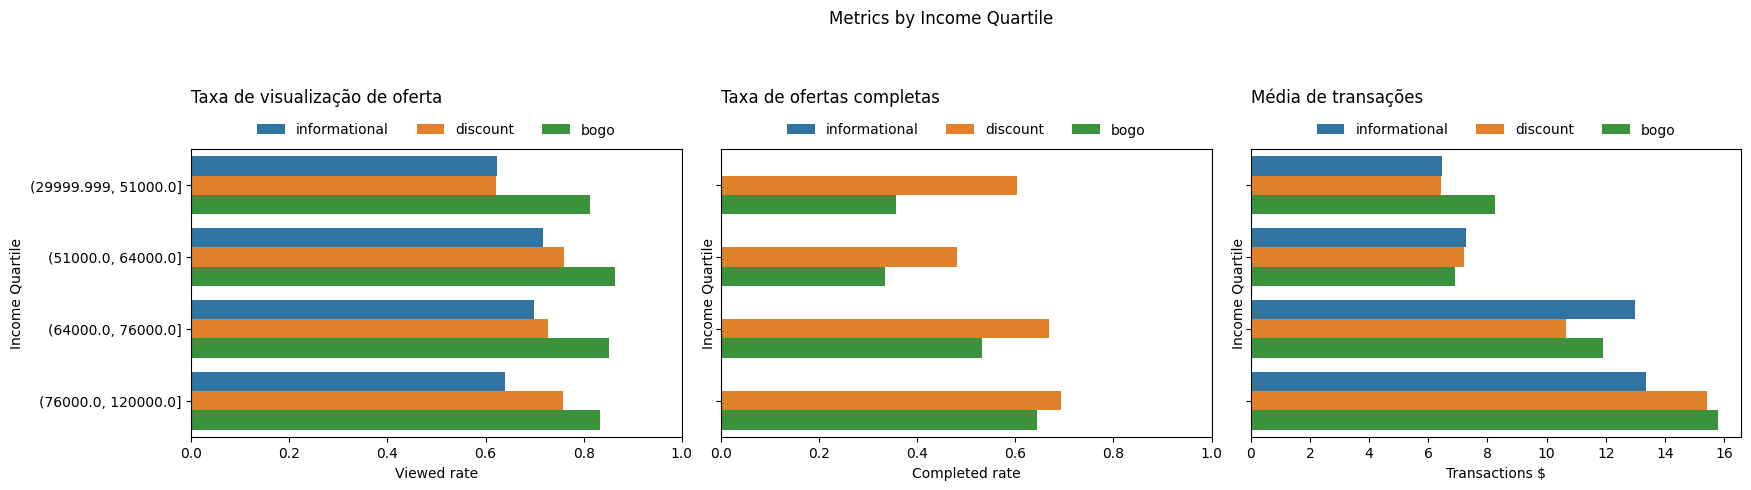

In [26]:
aux_fun.plot_grid_metrics(user_offer_df2, ['income_quartile', 'offer_type'], dodge=True)

In [27]:
portfolio.sort_values('offer_type')

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,3
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,8
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,5
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,6
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,9
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,2
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,7


By User Cluster

>**0: Meia idade, renda média e membro recente**  
>**1: Meia idade, renda média e membros antigos**  
>**2: Alta idade, renda alta e membro recente**  
>**3: Baixa idade, renda baixa e membro recente**     

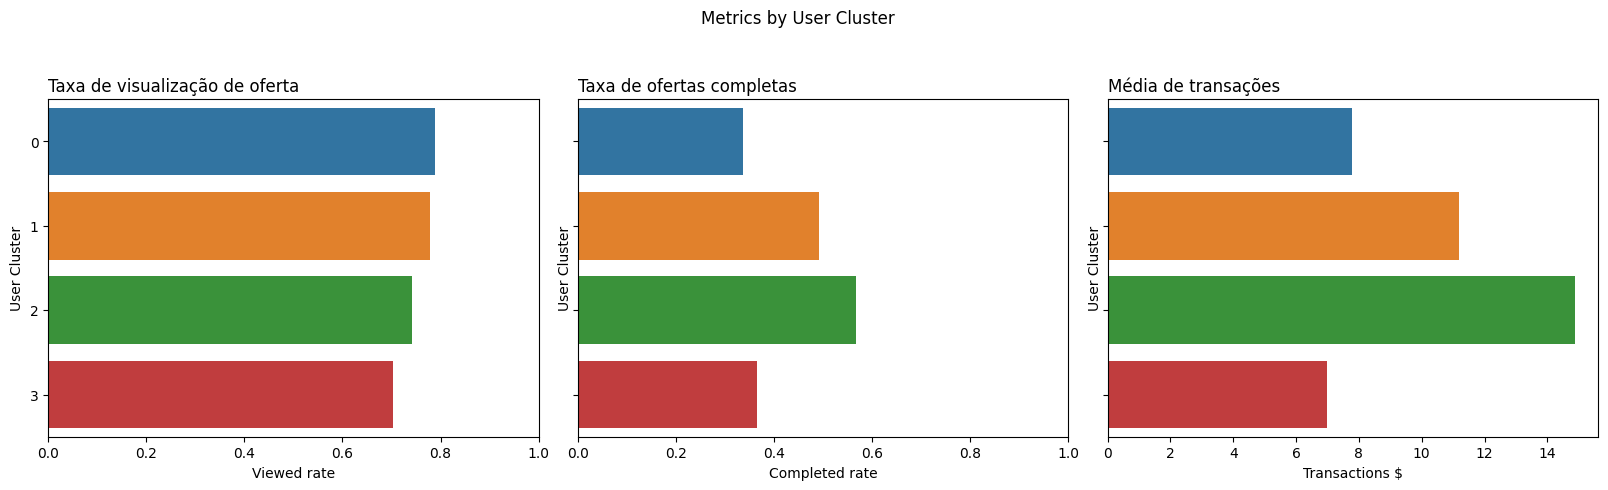

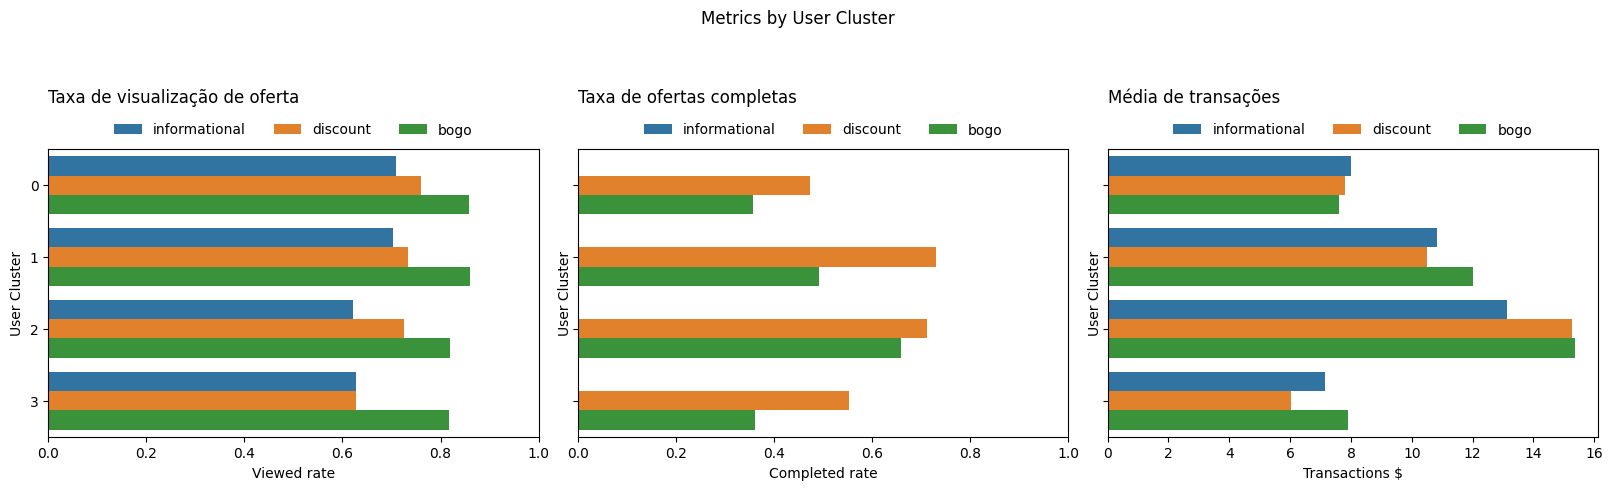

In [28]:
aux_fun.plot_grid_metrics(user_offer_df3, 'user_cluster', dodge=True)
aux_fun.plot_grid_metrics(user_offer_df3, ['user_cluster', 'offer_type'], dodge=True)

Olhando separadamente para cada oferta

#### Validações estatísticas

Buy one get one (BOGO) Offers

Nessa seção, vamos validar estatisticamente os melhores grupos para mandar ofertas.  
As duas métricas monitoradas serão a taxa de completação e a média de transação realizadas pelos usuários.

Para realizar as avaliações, usará teste de hipóteses para as métricas.

No caso da taxa de completadas, como se trata de uma proporção, usará teste de proporção entre duas amostras.   
Na avaliação da média de transação, usará teste t para diferença entre médias. 

Em todos esses testes, supõe-se que as distribuições são normais. 


---Complete Rate---------

(!=) Means of (17.999, 45.0] (0.36) and (45.0, 55.0] (0.3) are different (diff = 0.06). p-value = 0.0, confidence value = 0.05
(!=) Means of (17.999, 45.0] (0.36) and (55.0, 64.0] (0.44) are different (diff = -0.08). p-value = 0.0, confidence value = 0.05
(!=) Means of (17.999, 45.0] (0.36) and (64.0, 101.0] (0.45) are different (diff = -0.09). p-value = 0.0, confidence value = 0.05
(!=) Means of (45.0, 55.0] (0.3) and (55.0, 64.0] (0.44) are different (diff = -0.14). p-value = 0.0, confidence value = 0.05
(!=) Means of (45.0, 55.0] (0.3) and (64.0, 101.0] (0.45) are different (diff = -0.15). p-value = 0.0, confidence value = 0.05
(==) Means of (55.0, 64.0] (0.44) and (64.0, 101.0] (0.45) are equal (diff = -0.01). p-value = 0.06, confidence value = 0.05


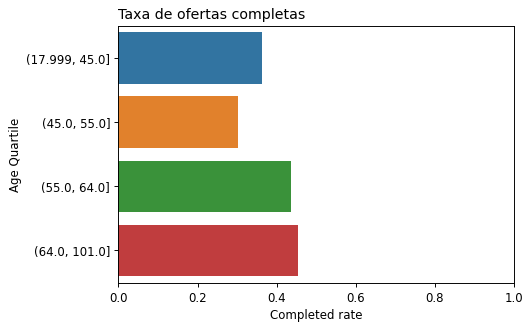


---Transactions---------

(!=) Means of (17.999, 45.0] (9.84) and (45.0, 55.0] (8.79) are different (diff = 1.05). p-value = 0.017, confidence value = 0.05
(!=) Means of (17.999, 45.0] (9.84) and (55.0, 64.0] (11.89) are different (diff = -2.05). p-value = 0.0, confidence value = 0.05
(!=) Means of (17.999, 45.0] (9.84) and (64.0, 101.0] (11.55) are different (diff = -1.71). p-value = 0.0, confidence value = 0.05
(!=) Means of (45.0, 55.0] (8.79) and (55.0, 64.0] (11.89) are different (diff = -3.1). p-value = 0.0, confidence value = 0.05
(!=) Means of (45.0, 55.0] (8.79) and (64.0, 101.0] (11.55) are different (diff = -2.76). p-value = 0.0, confidence value = 0.05
(==) Means of (55.0, 64.0] (11.89) and (64.0, 101.0] (11.55) are equal (diff = 0.34). p-value = 0.57, confidence value = 0.05


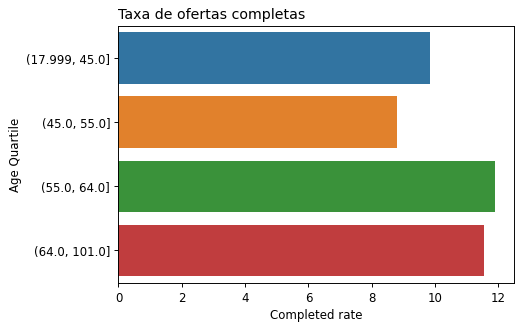

In [120]:
importlib.reload(aux_fun)
# Teste de hipoteses para cada grupo

bogo_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'bogo']

aux_fun.resume_differences(bogo_df, 'age_quartile')



---Complete Rate---------

(==) Means of (29999.999, 51000.0] (0.29) and (51000.0, 64000.0] (0.29) are equal (diff = 0.0). p-value = 0.878, confidence value = 0.05
(!=) Means of (29999.999, 51000.0] (0.29) and (64000.0, 76000.0] (0.45) are different (diff = -0.16). p-value = 0.0, confidence value = 0.05
(!=) Means of (29999.999, 51000.0] (0.29) and (76000.0, 120000.0] (0.54) are different (diff = -0.25). p-value = 0.0, confidence value = 0.05
(!=) Means of (51000.0, 64000.0] (0.29) and (64000.0, 76000.0] (0.45) are different (diff = -0.16). p-value = 0.0, confidence value = 0.05
(!=) Means of (51000.0, 64000.0] (0.29) and (76000.0, 120000.0] (0.54) are different (diff = -0.25). p-value = 0.0, confidence value = 0.05
(!=) Means of (64000.0, 76000.0] (0.45) and (76000.0, 120000.0] (0.54) are different (diff = -0.09). p-value = 0.0, confidence value = 0.05


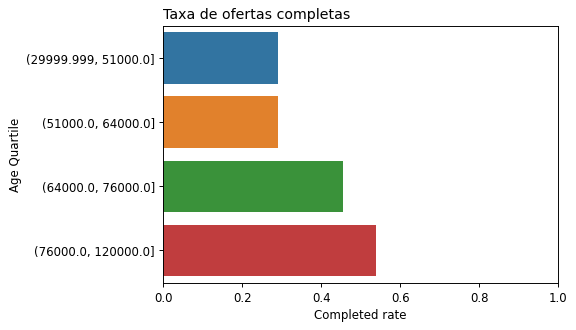


---Transactions---------

(!=) Means of (29999.999, 51000.0] (8.26) and (51000.0, 64000.0] (6.91) are different (diff = 1.35). p-value = 0.0, confidence value = 0.05
(!=) Means of (29999.999, 51000.0] (8.26) and (64000.0, 76000.0] (11.89) are different (diff = -3.63). p-value = 0.0, confidence value = 0.05
(!=) Means of (29999.999, 51000.0] (8.26) and (76000.0, 120000.0] (15.79) are different (diff = -7.53). p-value = 0.0, confidence value = 0.05
(!=) Means of (51000.0, 64000.0] (6.91) and (64000.0, 76000.0] (11.89) are different (diff = -4.98). p-value = 0.0, confidence value = 0.05
(!=) Means of (51000.0, 64000.0] (6.91) and (76000.0, 120000.0] (15.79) are different (diff = -8.88). p-value = 0.0, confidence value = 0.05
(!=) Means of (64000.0, 76000.0] (11.89) and (76000.0, 120000.0] (15.79) are different (diff = -3.9). p-value = 0.0, confidence value = 0.05


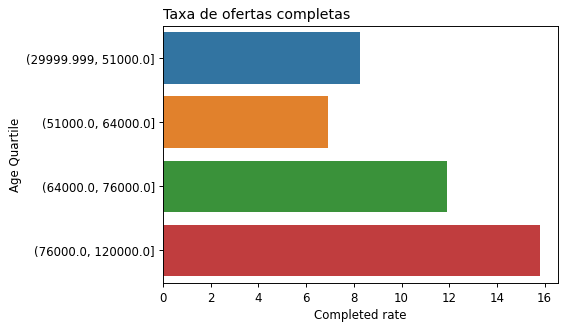

In [121]:
importlib.reload(aux_fun)
# Teste de hipoteses para cada grupo

bogo_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'bogo']

aux_fun.resume_differences(bogo_df, 'income_quartile')




---Complete Rate---------

(!=) Means of (-0.001, 0.57] (0.24) and (0.57, 0.98] (0.32) are different (diff = -0.08). p-value = 0.0, confidence value = 0.05
(!=) Means of (-0.001, 0.57] (0.24) and (0.98, 2.17] (0.51) are different (diff = -0.27). p-value = 0.0, confidence value = 0.05
(!=) Means of (-0.001, 0.57] (0.24) and (2.17, 4.99] (0.45) are different (diff = -0.21). p-value = 0.0, confidence value = 0.05
(!=) Means of (0.57, 0.98] (0.32) and (0.98, 2.17] (0.51) are different (diff = -0.19). p-value = 0.0, confidence value = 0.05
(!=) Means of (0.57, 0.98] (0.32) and (2.17, 4.99] (0.45) are different (diff = -0.13). p-value = 0.0, confidence value = 0.05
(!=) Means of (0.98, 2.17] (0.51) and (2.17, 4.99] (0.45) are different (diff = 0.06). p-value = 0.0, confidence value = 0.05


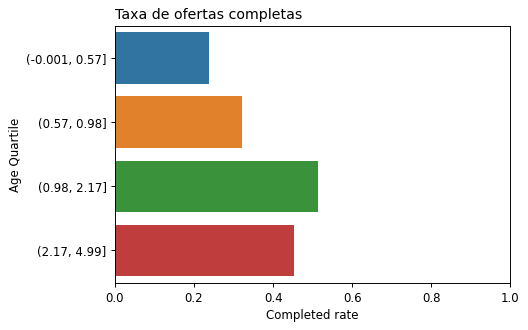


---Transactions---------

(!=) Means of (-0.001, 0.57] (5.98) and (0.57, 0.98] (8.48) are different (diff = -2.5). p-value = 0.0, confidence value = 0.05
(!=) Means of (-0.001, 0.57] (5.98) and (0.98, 2.17] (13.51) are different (diff = -7.53). p-value = 0.0, confidence value = 0.05
(!=) Means of (-0.001, 0.57] (5.98) and (2.17, 4.99] (13.34) are different (diff = -7.36). p-value = 0.0, confidence value = 0.05
(!=) Means of (0.57, 0.98] (8.48) and (0.98, 2.17] (13.51) are different (diff = -5.03). p-value = 0.0, confidence value = 0.05
(!=) Means of (0.57, 0.98] (8.48) and (2.17, 4.99] (13.34) are different (diff = -4.86). p-value = 0.0, confidence value = 0.05
(==) Means of (0.98, 2.17] (13.51) and (2.17, 4.99] (13.34) are equal (diff = 0.17). p-value = 0.766, confidence value = 0.05


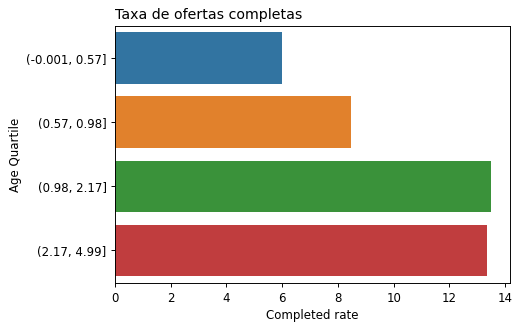

In [122]:
bogo_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'bogo']

aux_fun.resume_differences(bogo_df, 'member_years_quartile')



---Complete Rate---------

(!=) Means of F (0.5) and M (0.36) are different (diff = 0.14). p-value = 0.0, confidence value = 0.05
(!=) Means of F (0.5) and NI (0.09) are different (diff = 0.41). p-value = 0.0, confidence value = 0.05
(==) Means of F (0.5) and O (0.55) are equal (diff = -0.05). p-value = 0.074, confidence value = 0.05
(!=) Means of M (0.36) and NI (0.09) are different (diff = 0.27). p-value = 0.0, confidence value = 0.05
(!=) Means of M (0.36) and O (0.55) are different (diff = -0.19). p-value = 0.0, confidence value = 0.05
(!=) Means of NI (0.09) and O (0.55) are different (diff = -0.46). p-value = 0.0, confidence value = 0.05


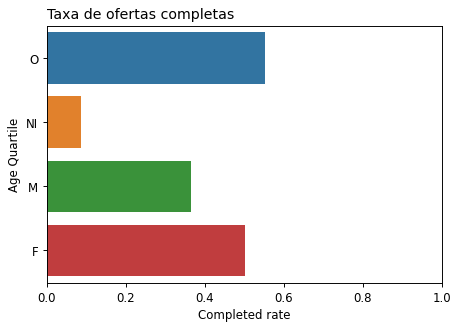


---Transactions---------

(!=) Means of F (12.85) and M (10.21) are different (diff = 2.64). p-value = 0.0, confidence value = 0.05
(!=) Means of F (12.85) and NI (3.55) are different (diff = 9.3). p-value = 0.0, confidence value = 0.05
(==) Means of F (12.85) and O (10.82) are equal (diff = 2.03). p-value = 0.297, confidence value = 0.05
(!=) Means of M (10.21) and NI (3.55) are different (diff = 6.66). p-value = 0.0, confidence value = 0.05
(==) Means of M (10.21) and O (10.82) are equal (diff = -0.61). p-value = 0.692, confidence value = 0.05
(!=) Means of NI (3.55) and O (10.82) are different (diff = -7.27). p-value = 0.0, confidence value = 0.05


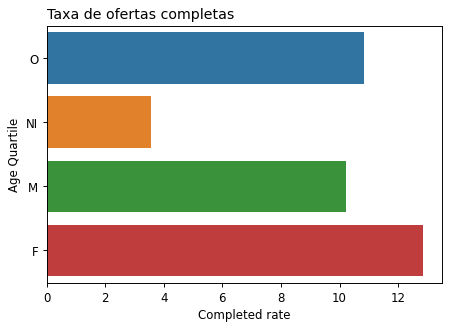

In [124]:
bogo_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'bogo']

aux_fun.resume_differences(bogo_df, 'gender')




---Complete Rate---------

(!=) Means of 0 (0.31) and 1 (0.42) are different (diff = -0.11). p-value = 0.0, confidence value = 0.05
(!=) Means of 0 (0.31) and 2 (0.54) are different (diff = -0.23). p-value = 0.0, confidence value = 0.05
(==) Means of 0 (0.31) and 3 (0.3) are equal (diff = 0.01). p-value = 0.137, confidence value = 0.05
(!=) Means of 1 (0.42) and 2 (0.54) are different (diff = -0.12). p-value = 0.0, confidence value = 0.05
(!=) Means of 1 (0.42) and 3 (0.3) are different (diff = 0.12). p-value = 0.0, confidence value = 0.05
(!=) Means of 2 (0.54) and 3 (0.3) are different (diff = 0.24). p-value = 0.0, confidence value = 0.05


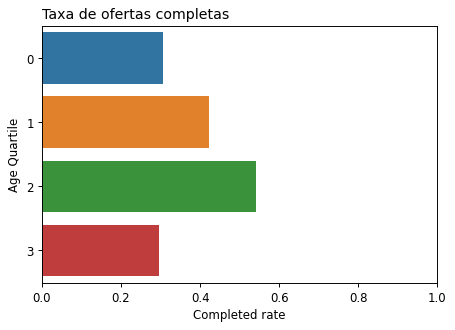


---Transactions---------

(!=) Means of 0 (7.61) and 1 (12.03) are different (diff = -4.42). p-value = 0.0, confidence value = 0.05
(!=) Means of 0 (7.61) and 2 (15.36) are different (diff = -7.75). p-value = 0.0, confidence value = 0.05
(==) Means of 0 (7.61) and 3 (7.9) are equal (diff = -0.29). p-value = 0.438, confidence value = 0.05
(!=) Means of 1 (12.03) and 2 (15.36) are different (diff = -3.33). p-value = 0.0, confidence value = 0.05
(!=) Means of 1 (12.03) and 3 (7.9) are different (diff = 4.13). p-value = 0.0, confidence value = 0.05
(!=) Means of 2 (15.36) and 3 (7.9) are different (diff = 7.46). p-value = 0.0, confidence value = 0.05


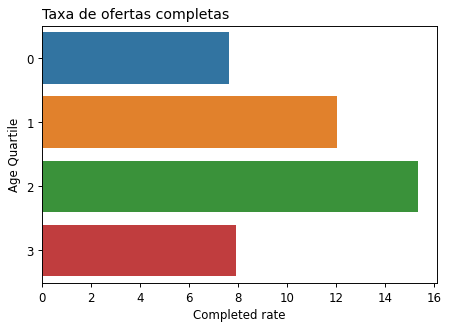

In [126]:
bogo_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'bogo']

aux_fun.resume_differences(bogo_df, 'user_cluster')


Logo, para idades, as ofertas do tipo BOGO tem maior efetividade para idades intermediárias para frente (a partir de 55 anos.)

Discount Offers


---Complete Rate---------

(!=) Means of (17.999, 45.0] (0.42) and (45.0, 55.0] (0.36) are different (diff = 0.06). p-value = 0.0, confidence value = 0.05
(!=) Means of (17.999, 45.0] (0.42) and (55.0, 64.0] (0.48) are different (diff = -0.06). p-value = 0.0, confidence value = 0.05
(!=) Means of (17.999, 45.0] (0.42) and (64.0, 101.0] (0.48) are different (diff = -0.06). p-value = 0.0, confidence value = 0.05
(!=) Means of (45.0, 55.0] (0.36) and (55.0, 64.0] (0.48) are different (diff = -0.12). p-value = 0.0, confidence value = 0.05
(!=) Means of (45.0, 55.0] (0.36) and (64.0, 101.0] (0.48) are different (diff = -0.12). p-value = 0.0, confidence value = 0.05
(==) Means of (55.0, 64.0] (0.48) and (64.0, 101.0] (0.48) are equal (diff = 0.0). p-value = 0.43, confidence value = 0.05


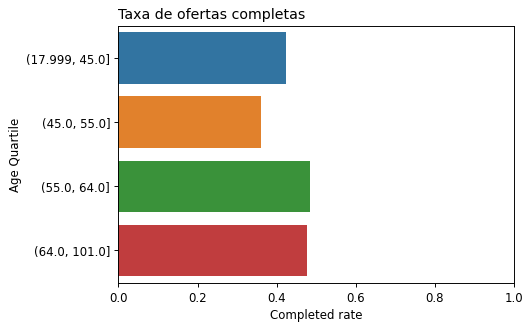


---Transactions---------

(==) Means of (17.999, 45.0] (7.77) and (45.0, 55.0] (8.04) are equal (diff = -0.27). p-value = 0.415, confidence value = 0.05
(!=) Means of (17.999, 45.0] (7.77) and (55.0, 64.0] (11.28) are different (diff = -3.51). p-value = 0.0, confidence value = 0.05
(!=) Means of (17.999, 45.0] (7.77) and (64.0, 101.0] (12.38) are different (diff = -4.61). p-value = 0.0, confidence value = 0.05
(!=) Means of (45.0, 55.0] (8.04) and (55.0, 64.0] (11.28) are different (diff = -3.24). p-value = 0.0, confidence value = 0.05
(!=) Means of (45.0, 55.0] (8.04) and (64.0, 101.0] (12.38) are different (diff = -4.34). p-value = 0.0, confidence value = 0.05
(==) Means of (55.0, 64.0] (11.28) and (64.0, 101.0] (12.38) are equal (diff = -1.1). p-value = 0.1, confidence value = 0.05


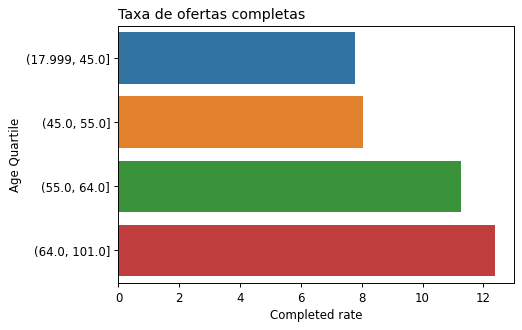

In [128]:
discount_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'discount']

aux_fun.resume_differences(discount_df, 'age_quartile')



---Complete Rate---------

(==) Means of (29999.999, 51000.0] (0.37) and (51000.0, 64000.0] (0.37) are equal (diff = 0.0). p-value = 0.325, confidence value = 0.05
(!=) Means of (29999.999, 51000.0] (0.37) and (64000.0, 76000.0] (0.49) are different (diff = -0.12). p-value = 0.0, confidence value = 0.05
(!=) Means of (29999.999, 51000.0] (0.37) and (76000.0, 120000.0] (0.53) are different (diff = -0.16). p-value = 0.0, confidence value = 0.05
(!=) Means of (51000.0, 64000.0] (0.37) and (64000.0, 76000.0] (0.49) are different (diff = -0.12). p-value = 0.0, confidence value = 0.05
(!=) Means of (51000.0, 64000.0] (0.37) and (76000.0, 120000.0] (0.53) are different (diff = -0.16). p-value = 0.0, confidence value = 0.05
(!=) Means of (64000.0, 76000.0] (0.49) and (76000.0, 120000.0] (0.53) are different (diff = -0.04). p-value = 0.0, confidence value = 0.05


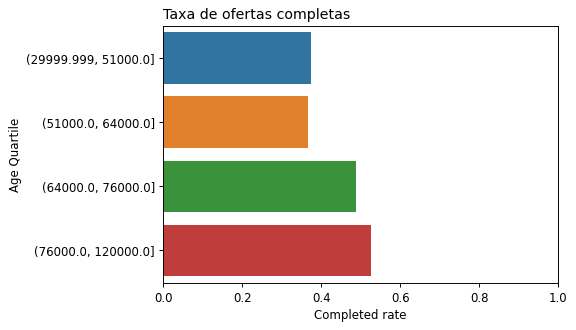


---Transactions---------

(!=) Means of (29999.999, 51000.0] (6.43) and (51000.0, 64000.0] (7.21) are different (diff = -0.78). p-value = 0.007, confidence value = 0.05
(!=) Means of (29999.999, 51000.0] (6.43) and (64000.0, 76000.0] (10.67) are different (diff = -4.24). p-value = 0.0, confidence value = 0.05
(!=) Means of (29999.999, 51000.0] (6.43) and (76000.0, 120000.0] (15.41) are different (diff = -8.98). p-value = 0.0, confidence value = 0.05
(!=) Means of (51000.0, 64000.0] (7.21) and (64000.0, 76000.0] (10.67) are different (diff = -3.46). p-value = 0.0, confidence value = 0.05
(!=) Means of (51000.0, 64000.0] (7.21) and (76000.0, 120000.0] (15.41) are different (diff = -8.2). p-value = 0.0, confidence value = 0.05
(!=) Means of (64000.0, 76000.0] (10.67) and (76000.0, 120000.0] (15.41) are different (diff = -4.74). p-value = 0.0, confidence value = 0.05


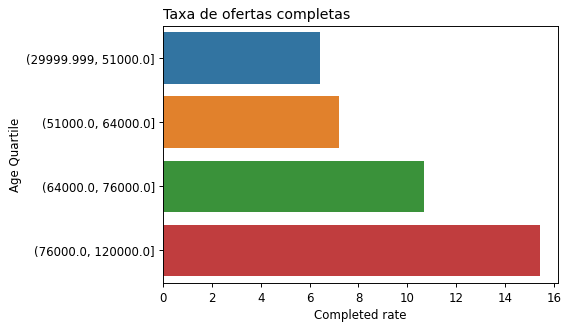

In [129]:
discount_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'discount']

aux_fun.resume_differences(discount_df, 'income_quartile')



---Complete Rate---------

(!=) Means of (-0.001, 0.57] (0.29) and (0.57, 0.98] (0.36) are different (diff = -0.07). p-value = 0.0, confidence value = 0.05
(!=) Means of (-0.001, 0.57] (0.29) and (0.98, 2.17] (0.53) are different (diff = -0.24). p-value = 0.0, confidence value = 0.05
(!=) Means of (-0.001, 0.57] (0.29) and (2.17, 4.99] (0.54) are different (diff = -0.25). p-value = 0.0, confidence value = 0.05
(!=) Means of (0.57, 0.98] (0.36) and (0.98, 2.17] (0.53) are different (diff = -0.17). p-value = 0.0, confidence value = 0.05
(!=) Means of (0.57, 0.98] (0.36) and (2.17, 4.99] (0.54) are different (diff = -0.18). p-value = 0.0, confidence value = 0.05
(==) Means of (0.98, 2.17] (0.53) and (2.17, 4.99] (0.54) are equal (diff = -0.01). p-value = 0.095, confidence value = 0.05


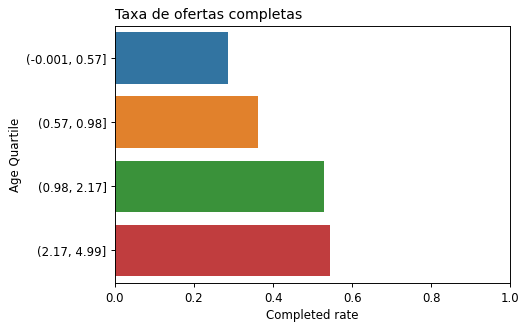


---Transactions---------

(!=) Means of (-0.001, 0.57] (6.64) and (0.57, 0.98] (8.01) are different (diff = -1.37). p-value = 0.002, confidence value = 0.05
(!=) Means of (-0.001, 0.57] (6.64) and (0.98, 2.17] (12.44) are different (diff = -5.8). p-value = 0.0, confidence value = 0.05
(!=) Means of (-0.001, 0.57] (6.64) and (2.17, 4.99] (11.62) are different (diff = -4.98). p-value = 0.0, confidence value = 0.05
(!=) Means of (0.57, 0.98] (8.01) and (0.98, 2.17] (12.44) are different (diff = -4.43). p-value = 0.0, confidence value = 0.05
(!=) Means of (0.57, 0.98] (8.01) and (2.17, 4.99] (11.62) are different (diff = -3.61). p-value = 0.0, confidence value = 0.05
(==) Means of (0.98, 2.17] (12.44) and (2.17, 4.99] (11.62) are equal (diff = 0.82). p-value = 0.116, confidence value = 0.05


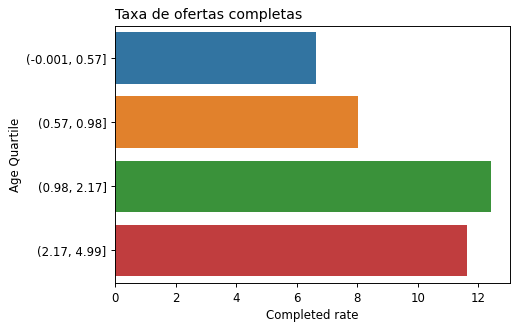

In [132]:
discount_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'discount']

aux_fun.resume_differences(discount_df, 'member_years_quartile')



---Complete Rate---------

(!=) Means of F (0.5) and M (0.44) are different (diff = 0.06). p-value = 0.0, confidence value = 0.05
(!=) Means of F (0.5) and NI (0.19) are different (diff = 0.31). p-value = 0.0, confidence value = 0.05
(!=) Means of F (0.5) and O (0.57) are different (diff = -0.07). p-value = 0.015, confidence value = 0.05
(!=) Means of M (0.44) and NI (0.19) are different (diff = 0.25). p-value = 0.0, confidence value = 0.05
(!=) Means of M (0.44) and O (0.57) are different (diff = -0.13). p-value = 0.0, confidence value = 0.05
(!=) Means of NI (0.19) and O (0.57) are different (diff = -0.38). p-value = 0.0, confidence value = 0.05


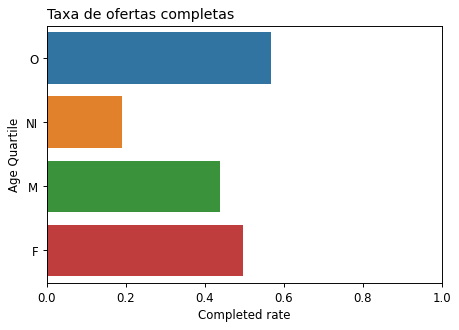


---Transactions---------

(!=) Means of F (12.1) and M (9.22) are different (diff = 2.88). p-value = 0.0, confidence value = 0.05
(!=) Means of F (12.1) and NI (3.99) are different (diff = 8.11). p-value = 0.0, confidence value = 0.05
(==) Means of F (12.1) and O (13.77) are equal (diff = -1.67). p-value = 0.38, confidence value = 0.05
(!=) Means of M (9.22) and NI (3.99) are different (diff = 5.23). p-value = 0.0, confidence value = 0.05
(!=) Means of M (9.22) and O (13.77) are different (diff = -4.55). p-value = 0.003, confidence value = 0.05
(!=) Means of NI (3.99) and O (13.77) are different (diff = -9.78). p-value = 0.0, confidence value = 0.05


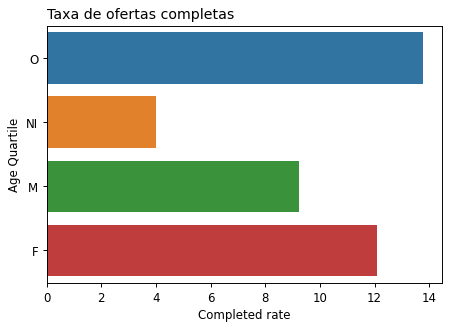

In [133]:
importlib.reload(aux_fun)
discount_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'discount']

aux_fun.resume_differences(discount_df, 'gender')


---Complete Rate---------

(!=) Means of F (0.5) and M (0.44) are different (diff = 0.06). p-value = 0.0, confidence value = 0.05
(!=) Means of F (0.5) and NI (0.19) are different (diff = 0.31). p-value = 0.0, confidence value = 0.05
(!=) Means of F (0.5) and O (0.57) are different (diff = -0.07). p-value = 0.015, confidence value = 0.05
(!=) Means of M (0.44) and NI (0.19) are different (diff = 0.25). p-value = 0.0, confidence value = 0.05
(!=) Means of M (0.44) and O (0.57) are different (diff = -0.13). p-value = 0.0, confidence value = 0.05
(!=) Means of NI (0.19) and O (0.57) are different (diff = -0.38). p-value = 0.0, confidence value = 0.05


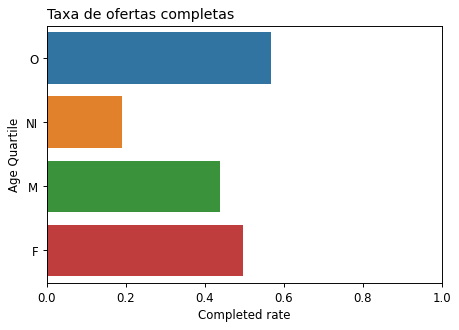


---Transactions---------

(!=) Means of F (12.1) and M (9.22) are different (diff = 2.88). p-value = 0.0, confidence value = 0.05
(!=) Means of F (12.1) and NI (3.99) are different (diff = 8.11). p-value = 0.0, confidence value = 0.05
(==) Means of F (12.1) and O (13.77) are equal (diff = -1.67). p-value = 0.38, confidence value = 0.05
(!=) Means of M (9.22) and NI (3.99) are different (diff = 5.23). p-value = 0.0, confidence value = 0.05
(!=) Means of M (9.22) and O (13.77) are different (diff = -4.55). p-value = 0.003, confidence value = 0.05
(!=) Means of NI (3.99) and O (13.77) are different (diff = -9.78). p-value = 0.0, confidence value = 0.05


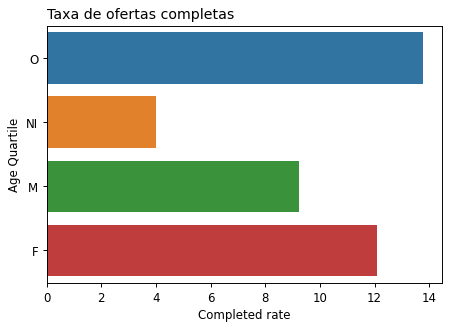

In [135]:
discount_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'discount']

aux_fun.resume_differences(discount_df, 'gender')



---Complete Rate---------

(!=) Means of 0 (0.36) and 1 (0.54) are different (diff = -0.18). p-value = 0.0, confidence value = 0.05
(!=) Means of 0 (0.36) and 2 (0.52) are different (diff = -0.16). p-value = 0.0, confidence value = 0.05
(==) Means of 0 (0.36) and 3 (0.35) are equal (diff = 0.01). p-value = 0.11, confidence value = 0.05
(!=) Means of 1 (0.54) and 2 (0.52) are different (diff = 0.02). p-value = 0.04, confidence value = 0.05
(!=) Means of 1 (0.54) and 3 (0.35) are different (diff = 0.19). p-value = 0.0, confidence value = 0.05
(!=) Means of 2 (0.52) and 3 (0.35) are different (diff = 0.17). p-value = 0.0, confidence value = 0.05


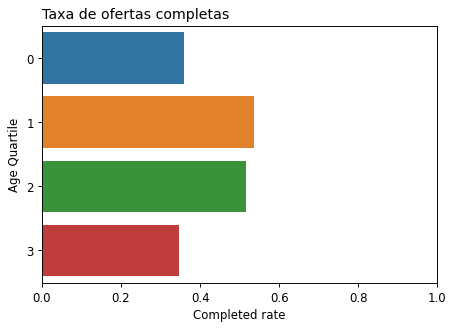


---Transactions---------

(!=) Means of 0 (7.81) and 1 (10.49) are different (diff = -2.68). p-value = 0.0, confidence value = 0.05
(!=) Means of 0 (7.81) and 2 (15.26) are different (diff = -7.45). p-value = 0.0, confidence value = 0.05
(!=) Means of 0 (7.81) and 3 (6.02) are different (diff = 1.79). p-value = 0.0, confidence value = 0.05
(!=) Means of 1 (10.49) and 2 (15.26) are different (diff = -4.77). p-value = 0.0, confidence value = 0.05
(!=) Means of 1 (10.49) and 3 (6.02) are different (diff = 4.47). p-value = 0.0, confidence value = 0.05
(!=) Means of 2 (15.26) and 3 (6.02) are different (diff = 9.24). p-value = 0.0, confidence value = 0.05


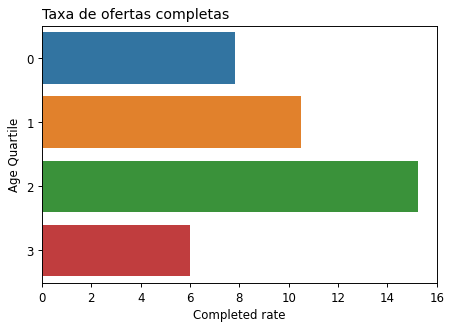

In [137]:

discount_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'discount']

aux_fun.resume_differences(discount_df, 'user_cluster')


Mesmo comportamento para Discount

Informational


---Transactions---------

(!=) Means of (17.999, 45.0] (9.88) and (45.0, 55.0] (7.49) are different (diff = 2.39). p-value = 0.0, confidence value = 0.05
(==) Means of (17.999, 45.0] (9.88) and (55.0, 64.0] (10.7) are equal (diff = -0.82). p-value = 0.301, confidence value = 0.05
(==) Means of (17.999, 45.0] (9.88) and (64.0, 101.0] (10.95) are equal (diff = -1.07). p-value = 0.128, confidence value = 0.05
(!=) Means of (45.0, 55.0] (7.49) and (55.0, 64.0] (10.7) are different (diff = -3.21). p-value = 0.0, confidence value = 0.05
(!=) Means of (45.0, 55.0] (7.49) and (64.0, 101.0] (10.95) are different (diff = -3.46). p-value = 0.0, confidence value = 0.05
(==) Means of (55.0, 64.0] (10.7) and (64.0, 101.0] (10.95) are equal (diff = -0.25). p-value = 0.736, confidence value = 0.05


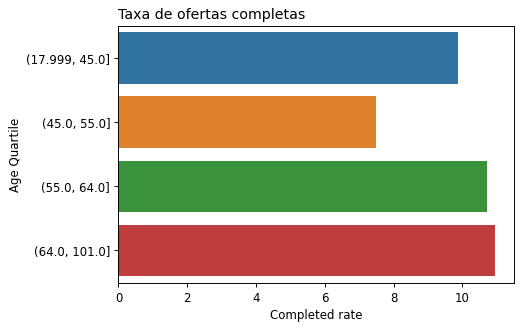

In [144]:
importlib.reload(aux_fun)
informa_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'informational']

aux_fun.resume_differences(informa_df, 'age_quartile')

# informa_df['offer_type'].unique()[0]


---Transactions---------

(==) Means of (29999.999, 51000.0] (6.47) and (51000.0, 64000.0] (7.27) are equal (diff = -0.8). p-value = 0.098, confidence value = 0.05
(!=) Means of (29999.999, 51000.0] (6.47) and (64000.0, 76000.0] (12.99) are different (diff = -6.52). p-value = 0.0, confidence value = 0.05
(!=) Means of (29999.999, 51000.0] (6.47) and (76000.0, 120000.0] (13.35) are different (diff = -6.88). p-value = 0.0, confidence value = 0.05
(!=) Means of (51000.0, 64000.0] (7.27) and (64000.0, 76000.0] (12.99) are different (diff = -5.72). p-value = 0.0, confidence value = 0.05
(!=) Means of (51000.0, 64000.0] (7.27) and (76000.0, 120000.0] (13.35) are different (diff = -6.08). p-value = 0.0, confidence value = 0.05
(==) Means of (64000.0, 76000.0] (12.99) and (76000.0, 120000.0] (13.35) are equal (diff = -0.36). p-value = 0.69, confidence value = 0.05


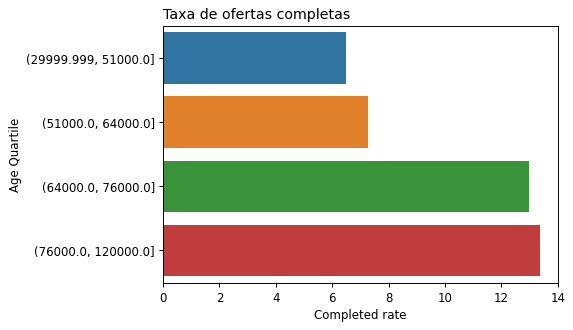

In [145]:
informa_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'informational']

aux_fun.resume_differences(informa_df, 'income_quartile')



---Transactions---------

(!=) Means of (-0.001, 0.57] (4.71) and (0.57, 0.98] (7.63) are different (diff = -2.92). p-value = 0.0, confidence value = 0.05
(!=) Means of (-0.001, 0.57] (4.71) and (0.98, 2.17] (14.08) are different (diff = -9.37). p-value = 0.0, confidence value = 0.05
(!=) Means of (-0.001, 0.57] (4.71) and (2.17, 4.99] (11.84) are different (diff = -7.13). p-value = 0.0, confidence value = 0.05
(!=) Means of (0.57, 0.98] (7.63) and (0.98, 2.17] (14.08) are different (diff = -6.45). p-value = 0.0, confidence value = 0.05
(!=) Means of (0.57, 0.98] (7.63) and (2.17, 4.99] (11.84) are different (diff = -4.21). p-value = 0.0, confidence value = 0.05
(!=) Means of (0.98, 2.17] (14.08) and (2.17, 4.99] (11.84) are different (diff = 2.24). p-value = 0.003, confidence value = 0.05


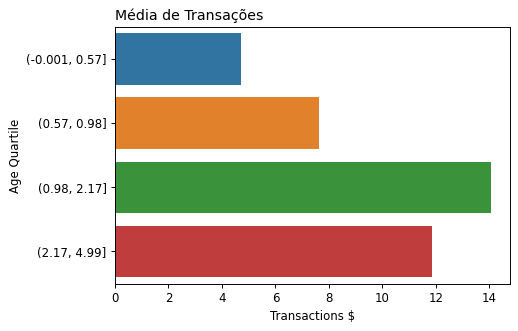

In [41]:
informa_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'informational']

aux_fun.resume_differences(informa_df, 'member_years_quartile')



---Transactions---------

(!=) Means of F (12.41) and M (9.27) are different (diff = 3.14). p-value = 0.0, confidence value = 0.05
(!=) Means of F (12.41) and NI (1.93) are different (diff = 10.48). p-value = 0.0, confidence value = 0.05
(==) Means of F (12.41) and O (15.26) are equal (diff = -2.85). p-value = 0.239, confidence value = 0.05
(!=) Means of M (9.27) and NI (1.93) are different (diff = 7.34). p-value = 0.0, confidence value = 0.05
(!=) Means of M (9.27) and O (15.26) are different (diff = -5.99). p-value = 0.004, confidence value = 0.05
(!=) Means of NI (1.93) and O (15.26) are different (diff = -13.33). p-value = 0.0, confidence value = 0.05


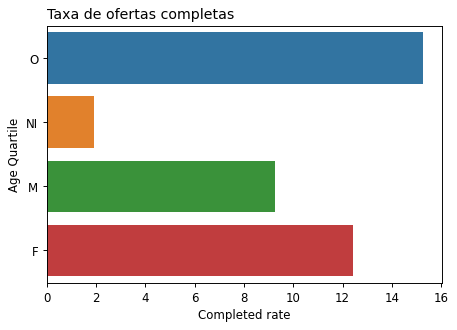

In [146]:
informa_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'informational']

aux_fun.resume_differences(informa_df, 'gender')


#### Summarize the best groups

For BOGO

In [57]:
importlib.reload(aux_fun)

bogo_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'bogo']

columns = ['age_quartile', 'income_quartile', 'gender', 
    'member_years_quartile',  'user_cluster']
dfs = []

for column in columns:
    dfs.append(aux_fun.best_groups_means(bogo_df, column, 'tra_offer_infl'))

pd.concat(dfs)

,best_groups,best_value,min_gain
age_quartile,"[(55.0, 64.0], (64.0, 101.0]]",11.89,2.05
income_quartile,"[(76000.0, 120000.0]]",15.79,3.90
gender,"[F, O]",12.85,2.64
member_years_quartile,"[(0.98, 2.17], (2.17, 4.99]]",13.51,5.03


In [58]:
importlib.reload(aux_fun)

bogo_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'bogo']

columns = ['age_quartile', 'income_quartile', 'gender', 
    'member_years_quartile',  'user_cluster']
dfs = []

for column in columns:
    dfs.append(aux_fun.best_groups_means(bogo_df, column, 'completed_after_view_rate'))

pd.concat(dfs)

,best_groups,best_value,min_gain
age_quartile,"[(64.0, 101.0], (55.0, 64.0]]",0.45,0.09
income_quartile,"[(76000.0, 120000.0]]",0.54,0.09
gender,"[O, F]",0.55,0.19
member_years_quartile,"[(0.98, 2.17]]",0.51,0.06


Discount

In [59]:
importlib.reload(aux_fun)

discount_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'discount']

columns = ['age_quartile', 'income_quartile', 'gender', 
    'member_years_quartile',  'user_cluster']
dfs = []

for column in columns:
    dfs.append(aux_fun.best_groups_means(discount_df, column, 'tra_offer_infl'))

pd.concat(dfs)

,best_groups,best_value,min_gain
age_quartile,"[(64.0, 101.0], (55.0, 64.0]]",12.38,4.34
income_quartile,"[(76000.0, 120000.0]]",15.41,4.74
gender,"[O, F]",13.77,4.55
member_years_quartile,"[(0.98, 2.17], (2.17, 4.99]]",12.44,4.43


In [60]:
importlib.reload(aux_fun)

discount_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'discount']

columns = ['age_quartile', 'income_quartile', 'gender', 
    'member_years_quartile',  'user_cluster']
dfs = []

for column in columns:
    dfs.append(aux_fun.best_groups_means(discount_df, column, 'completed_after_view_rate'))

pd.concat(dfs)

,best_groups,best_value,min_gain
age_quartile,"[(55.0, 64.0], (64.0, 101.0]]",0.48,0.06
income_quartile,"[(76000.0, 120000.0]]",0.53,0.04
gender,[O],0.57,0.07
member_years_quartile,"[(2.17, 4.99], (0.98, 2.17]]",0.54,0.18


Informational

In [61]:
importlib.reload(aux_fun)

informational_df = user_offer_df3.loc[user_offer_df3['offer_type'] == 'informational']

columns = ['age_quartile', 'income_quartile', 'gender', 
    'member_years_quartile',  'user_cluster']
dfs = []

for column in columns:
    dfs.append(aux_fun.best_groups_means(informational_df, column, 'tra_offer_infl'))

pd.concat(dfs)

,best_groups,best_value,min_gain
age_quartile,"[(64.0, 101.0], (55.0, 64.0], (17.999, 45.0]]",10.95,3.46
income_quartile,"[(76000.0, 120000.0], (64000.0, 76000.0]]",13.35,6.08
gender,"[O, F]",15.26,5.99
member_years_quartile,"[(0.98, 2.17]]",14.08,2.24


For groups perpectives

In [157]:
# Fazer o mesmo, porém, para cada grupo dentro do dataset
aux_fun.resume_best_for_groups(user_offer_df3, 'age_quartile', 'tra_offer_infl')

,best_groups,best_value,min_gain
category,,,
"(17.999, 45.0]","[informational, bogo]",9.88,2.11
"(45.0, 55.0]","[bogo, discount]",8.79,1.30
"(55.0, 64.0]","[bogo, discount, informational]",11.89,0.00
"(64.0, 101.0]","[discount, bogo, informational]",12.38,0.00


In [156]:
aux_fun.resume_best_for_groups(user_offer_df3, 'income_quartile', 'tra_offer_infl')

,best_groups,best_value,min_gain
category,,,
"(29999.999, 51000.0]",[bogo],8.26,1.79
"(51000.0, 64000.0]","[informational, discount, bogo]",7.27,0.00
"(64000.0, 76000.0]","[informational, bogo]",12.99,2.32
"(76000.0, 120000.0]","[bogo, discount]",15.79,2.44


In [155]:
aux_fun.resume_best_for_groups(user_offer_df3, 'member_years_quartile', 'tra_offer_infl')

,best_groups,best_value,min_gain
category,,,
"(-0.001, 0.57]","[discount, bogo]",6.64,1.93
"(0.57, 0.98]","[bogo, discount, informational]",8.48,0.00
"(0.98, 2.17]","[informational, bogo]",14.08,1.64
"(2.17, 4.99]",[bogo],13.34,1.50


In [153]:
aux_fun.resume_best_for_groups(user_offer_df3, 'gender', 'tra_offer_infl')

,best_groups,best_value,min_gain
category,,,
F,"[bogo, informational, discount]",12.85,0.00
M,[bogo],10.21,0.94
NI,[discount],3.99,0.44
O,"[informational, discount, bogo]",15.26,0.00
